<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: fine-tune SAM (segment anything) on a custom dataset

In this notebook, we'll reproduce the [MedSAM](https://github.com/bowang-lab/MedSAM) project, which fine-tunes [SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam) on a dataset of medical images. For demo purposes, we'll use a toy dataset, but this can easily be scaled up.

Resources used to create this notebook (thanks 🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [MedSAM repository](https://github.com/bowang-lab/MedSAM).

## Set-up environment

We first install 🤗 Transformers and 🤗 Datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [2]:
!pip install -q datasets

We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [3]:
!pip install -q monai

## Load dataset

Here we load a small dataset of 130 (image, ground truth mask) pairs.

To load your own images and masks, refer to the bottom of my [SAM inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb).

See also [this guide](https://huggingface.co/docs/datasets/image_dataset). 

In [2]:
from datasets import load_dataset

dataset = load_dataset("nielsr/breast-cancer", split="train")

Using custom data configuration nielsr--breast-cancer-c16ee7932c43ffa3
Reusing dataset parquet (/root/.cache/huggingface/datasets/nielsr___parquet/nielsr--breast-cancer-c16ee7932c43ffa3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [33]:
from cordmap.data import SUVIImageDataset

chosen_channels = ("Product.suvi_l2_ci171", "Product.suvi_l2_ci284", "Product.suvi_l2_ci304")
d = SUVIImageDataset("../datasets/cordmap-1/good_index.csv", "../datasets/cordmap-1/", image_dim=(1024, 1024), channels=chosen_channels)

In [83]:
import cv2

In [205]:
images = []
masks = []
for i in range(100):
    try:
        this_entry = d[i]
    except:
        pass
    else:
        images.append(np.transpose(this_entry[0], [1, 2, 0]))
        masks.append(cv2.resize(this_entry[1], dsize=(256, 256), interpolation=cv2.INTER_NEAREST) == 3)

In [206]:
images = np.array(images)
masks = np.array(masks)

images = np.sign(images) * np.power(np.abs(images), 0.25)

In [207]:
factors = dict()
for i in range(images.shape[-1]):
    low, high = np.percentile(images[:, :, :, i], 3), np.percentile(images[:, :, :, i], 99.99)
    factors[i] = low, high

In [208]:
for (c, (low, high)) in factors.items():
    images[:, :, :, c] = np.clip((images[:, :, :, c] - low) / (high - low) * 255, 0, 255)
    
images = images.astype(np.uint8)

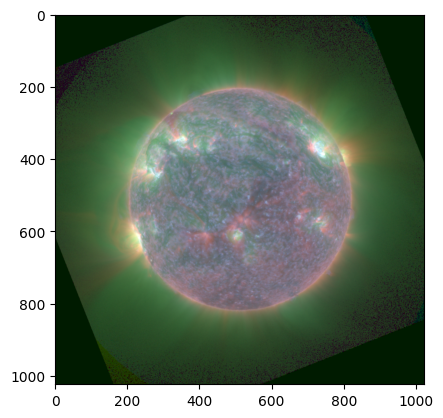

In [209]:
fig, ax = plt.subplots()
ax.imshow(images[-1])
fig.show()

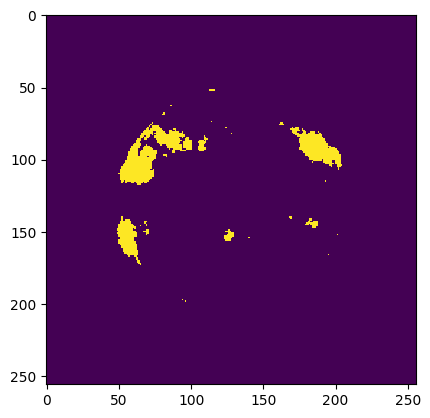

In [210]:
fig, ax = plt.subplots()
ax.imshow(masks[-1], interpolation='None')
fig.show()

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [211]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    bbox = [24, 24, 1000, 1000]
    return bbox

In [212]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [213]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [214]:
dataset = [{"image": img, "label": m} for img, m in zip(images, masks)]

In [215]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [216]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [217]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [218]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [219]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Load the model

In [220]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Train the model

In [221]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [222]:
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [223]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 25

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 0
Mean loss: 0.8766135398079368


100%|██████████| 34/34 [00:29<00:00,  1.15it/s]


EPOCH: 1
Mean loss: 0.5688614450833377


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 2
Mean loss: 0.49721935391426086


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 3
Mean loss: 0.4409600855673061


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 4
Mean loss: 0.4013725676957299


100%|██████████| 34/34 [00:29<00:00,  1.13it/s]


EPOCH: 5
Mean loss: 0.3738305594991235


100%|██████████| 34/34 [00:30<00:00,  1.13it/s]


EPOCH: 6
Mean loss: 0.3601440498057534


100%|██████████| 34/34 [00:30<00:00,  1.13it/s]


EPOCH: 7
Mean loss: 0.33691948389305787


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 8
Mean loss: 0.32655605936751647


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 9
Mean loss: 0.3095920541707207


100%|██████████| 34/34 [00:30<00:00,  1.13it/s]


EPOCH: 10
Mean loss: 0.30746174384565916


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 11
Mean loss: 0.30076537062140074


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 12
Mean loss: 0.2925305831081727


100%|██████████| 34/34 [00:30<00:00,  1.13it/s]


EPOCH: 13
Mean loss: 0.29373440497061787


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 14
Mean loss: 0.28514595417415395


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 15
Mean loss: 0.2783125884392682


100%|██████████| 34/34 [00:29<00:00,  1.15it/s]


EPOCH: 16
Mean loss: 0.27046989167437835


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 17
Mean loss: 0.26818037471350503


100%|██████████| 34/34 [00:29<00:00,  1.13it/s]


EPOCH: 18
Mean loss: 0.26500073864179496


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 19
Mean loss: 0.26064498722553253


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 20
Mean loss: 0.2587360704646391


100%|██████████| 34/34 [00:30<00:00,  1.13it/s]


EPOCH: 21
Mean loss: 0.2574162202722886


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 22
Mean loss: 0.24908115495653713


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 23
Mean loss: 0.24637218871537378


100%|██████████| 34/34 [00:30<00:00,  1.13it/s]

EPOCH: 24
Mean loss: 0.24522242125342875


## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [224]:
images = []
masks = []
for i in range(100, len(d)):
    try:
        this_entry = d[i]
    except:
        pass
    else:
        images.append(np.transpose(this_entry[0], [1, 2, 0]))
        masks.append(cv2.resize(this_entry[1], dsize=(256, 256), interpolation=cv2.INTER_NEAREST) == 3)
        
images = np.array(images)
masks = np.array(masks)

images = np.sign(images) * np.power(np.abs(images), 0.25)

for (c, (low, high)) in factors.items():
    images[:, :, :, c] = np.clip((images[:, :, :, c] - low) / (high - low) * 255, 0, 255)
    
images = images.astype(np.uint8)

new_dataset = [{"image": img, "label": m} for img, m in zip(images, masks)]

In [275]:
idx = 4

image = new_dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(new_dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [276]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [277]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

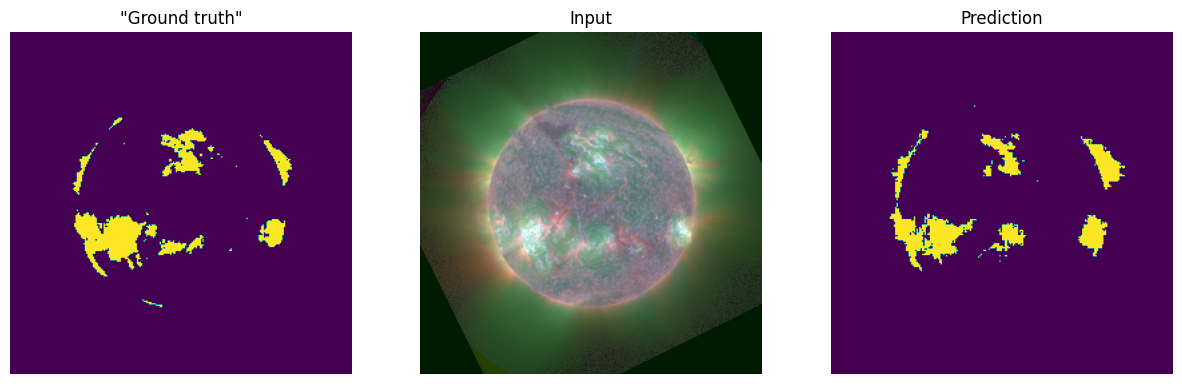

In [278]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 7))
axs[1].imshow(image)
axs[1].set_title("Input")
axs[0].imshow(ground_truth_mask)
axs[0].set_title('"Ground truth"')
axs[2].imshow(medsam_seg)
axs[2].set_title("Prediction")

for ax in axs:
    ax.set_axis_off()
    
fig.show()

In [279]:
original_model = SamModel.from_pretrained("facebook/sam-vit-base")
original_model.to(device)
print()

In [280]:
original_model.eval()

# forward pass
with torch.no_grad():
  outputs = original_model(**inputs, multimask_output=False)

In [281]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

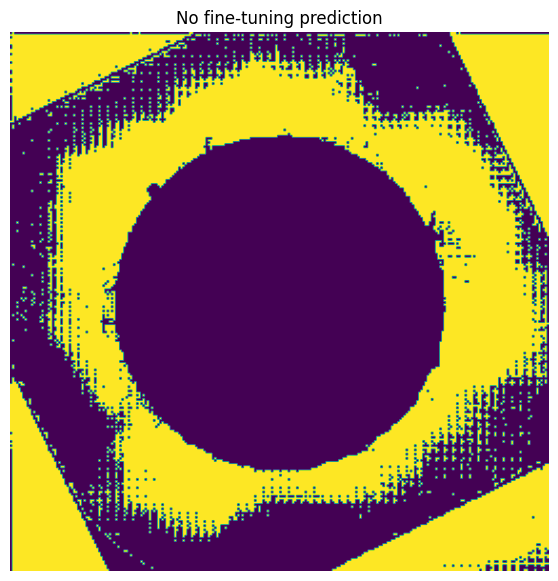

In [282]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(medsam_seg)
ax.set_title("No fine-tuning prediction")
ax.set_axis_off()
fig.show()